In [99]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from torchvision import models, transforms

import nltk
from nltk.tokenize import word_tokenize
from PIL import Image
import os
import json
import numpy as np
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaczm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [123]:
from datasets import load_dataset

dataset = load_dataset("RIW/small-coco")

In [124]:
images = [image['image'] for image in dataset['train']]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'url', 'key', 'status', 'error_message', 'width', 'height', 'original_width', 'original_height', 'exif', 'sha256'],
        num_rows: 9890
    })
    validation: Dataset({
        features: ['image', 'caption', 'url', 'key', 'status', 'error_message', 'width', 'height', 'original_width', 'original_height', 'exif', 'sha256'],
        num_rows: 9893
    })
})

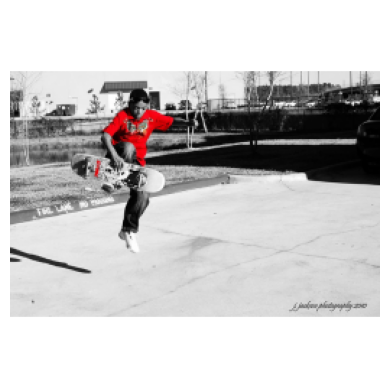

A kid doing a trick with a skate board on sidewalk.


In [5]:
import random 

random_index = random.randint(0, len(dataset['train']) - 1)
sample = dataset['train'][random_index]


image = sample['image']  
caption = sample['caption']

plt.imshow(image)
plt.axis('off')  
plt.show()

print(caption)

In [6]:
nltk.data.path.append('C:/Users/kaczm/OneDrive/Pulpit/projects/Transfer Learning')
nltk.download('punkt', download_dir='C:/Users/kaczm/OneDrive/Pulpit/projects/Transfer Learning')

[nltk_data] Downloading package punkt to
[nltk_data]     C:/Users/kaczm/OneDrive/Pulpit/projects/Transfer
[nltk_data]     Learning...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
print(nltk.data.find('tokenizers/punkt'))

C:\Users\kaczm\AppData\Roaming\nltk_data\tokenizers\punkt


In [7]:
nltk.data.path.insert(0, 'C:/Users/kaczm/OneDrive/Pulpit/projects/Transfer Learning')

# Confirm that the custom directory is being used
print(nltk.data.find('tokenizers/punkt'))

C:\Users\kaczm\OneDrive\Pulpit\projects\Transfer Learning\tokenizers\punkt


In [36]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaczm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [125]:
# Ok so my steps is: build a vocabulary, tokenize the captions, build a dataset, build a dataloader, build a model, train the model, evaluate the model

# Step 1: Build a vocabulary

captions = [sample['caption'] for sample in dataset['train']]
tokens = [word_tokenize(caption.lower()) for caption in captions]



In [29]:
# let's save captions and tokens to the working directory
with open('captions.json', 'w') as f:
    json.dump(captions, f)

with open('tokens.json', 'w') as f:
    json.dump(tokens, f)

In [126]:

vocab = Counter()
for token in tokens:
    vocab.update(token)

special_tokens = {
    "<PAD>": 0,
    "<UNK>": 1,
    "<START>": 2,
    "<END>": 3
}

vocab_from_tokens = {word: idx + len(special_tokens) 
                    for idx, (word, _) in enumerate(vocab.items())}

# Combine them in the correct order
vocab = {**special_tokens, **vocab_from_tokens}

# Let's save the vocabulary to the working directory
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)



In [127]:
# After building the vocabulary, we can index the captions

indexed_captions = [[vocab["<START>"]] + [vocab.get(token, vocab["<UNK>"]) for token in caption] + [vocab["<END>"]] 
                   for caption in tokens]

In [32]:
# output index captions to the working directory

with open('indexed_captions.json', 'w') as f:
    json.dump(indexed_captions, f)

In [3]:
# load vocab function

def load_vocab(path):
    with open(path, 'r') as f:
        vocab = json.load(f)
    return vocab

vocab = load_vocab('vocab.json')

# load tokenized captions

def load_tokens(path):
    with open(path, 'r') as f:
        tokens = json.load(f)
    return tokens

tokenized_captions = load_tokens('tokens.json')

# load indexed captions

def load_indexed_captions(path):
    with open(path, 'r') as f:
        indexed_captions = json.load(f)
    return indexed_captions

indexed_captions = load_indexed_captions('indexed_captions.json')



In [33]:
len(indexed_captions)

9890

In [128]:
# Now build a dataset
from torchvision.transforms import ToTensor

def collate_fn(batch):
    images = torch.stack([sample[0] for sample in batch]) 
    captions = torch.stack([sample[1] for sample in batch])  
    return images, captions

class CocoDataset(Dataset):
    def __init__(self, images, captions, vocab, transform=None, max_caption_length=60):
        self.images = images
        self.captions = captions
        self.vocab = vocab
        self.transform = transform or ToTensor()  # Default to tensor conversion
        self.max_caption_length = max_caption_length
        print(f"Initialized CocoDataset with {len(self.images)} samples.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        if self.transform:
            image = self.transform(image)

        indexed_caption = self.captions[index]

        # Pad or truncate caption
        if len(indexed_caption) > self.max_caption_length:
            indexed_caption = indexed_caption[:self.max_caption_length]
        else:
            indexed_caption += [self.vocab["<PAD>"]] * (self.max_caption_length - len(indexed_caption))

        return image, torch.tensor(indexed_caption)





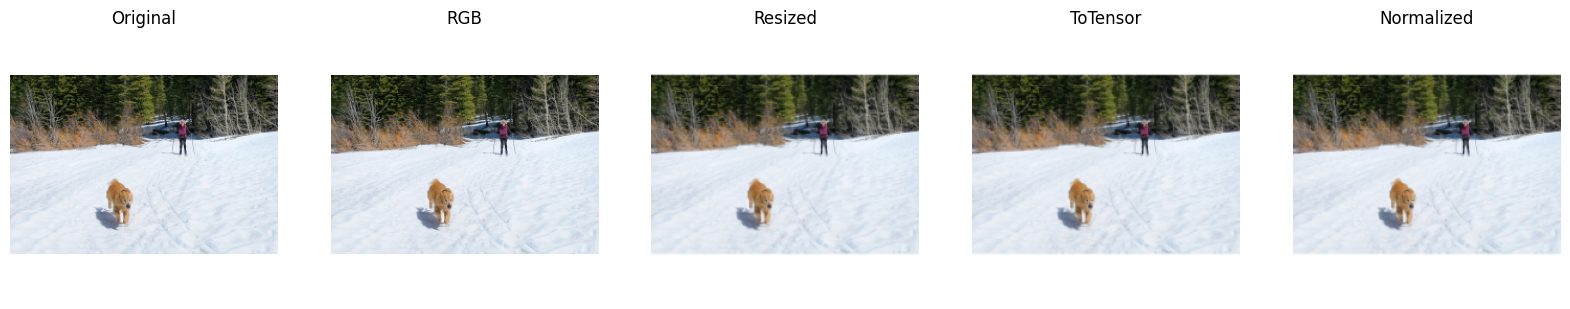

In [ ]:
# I will transforms the images but want to see the whole pipeline whether somethinf goes wrong
def show_transformation_steps(img):
    
    plt.figure(figsize=(20, 4))
    

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    rgb_img = img.convert('RGB')
    plt.subplot(1, 5, 2)
    plt.imshow(rgb_img)
    plt.title('RGB')
    plt.axis('off')
    
    resized = Resize((224, 224))(rgb_img)
    plt.subplot(1, 5, 3)
    plt.imshow(resized)
    plt.title('Resized')
    plt.axis('off')
    
    tensor_img = ToTensor()(resized)
    plt.subplot(1, 5, 4)
    plt.imshow(tensor_img.permute(1, 2, 0))
    plt.title('ToTensor')
    plt.axis('off')
    
    normalized = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor_img)
    # back to range [0,1] for visualization
    denorm_img = normalized.clone()
    for t, m, s in zip(denorm_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    plt.subplot(1, 5, 5)
    plt.imshow(denorm_img.permute(1, 2, 0).clamp(0, 1))
    plt.title('Normalized')
    plt.axis('off')
    
    plt.show()


idx = random.randint(0, len(images)-1)  # random image
sample_image = images[idx]
show_transformation_steps(sample_image)

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Lambda

transform = Compose([
    Lambda(lambda img: img.convert("RGB")),
    Resize((224, 224)),
    ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images = [sample['image'] for sample in dataset['train']]

dataset = CocoDataset(images, indexed_captions, vocab, transform=transform, max_caption_length=60)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

for batch_images, batch_captions in dataloader:
    print(batch_images.shape)  # [batch_size, 3, 224, 224]
    print(batch_captions.shape)  # [batch_size, max_caption_length]
    break

Initialized CocoDataset with 9890 samples.
torch.Size([32, 3, 224, 224])
torch.Size([32, 60])


In [17]:
# save the dataset to the working directory
torch.save(dataset, 'dataset.pt')


In [ ]:
# Next step is importing the pretrained resnet model, unfreezing the last layer and replacing the last layer with a linear layer with the number of classes equal to the size of the vocabulary

# pretrained ResNet model

resnet = models.resnet50(pretrained=True)

# Freeze all layers except the last one

for param in resnet.parameters():
    param.requires_grad = False


c:\Users\kaczm\.virtualenvs\Transfer_Learning-vQmDrh-c\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaczm\.virtualenvs\Transfer_Learning-vQmDrh-c\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
'''
import torch.nn as nn

class ImageCaptioningModel(nn.Module):
    def __init__(self, base_model, vocab_size, embed_size=256, hidden_size=256, seq_length=20):
        super(ImageCaptioningModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Identity()
        
        # Image feature processing
        self.feature_proj = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Text processing
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=vocab["<PAD>"])
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)
        
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embed.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, images, captions=None):
        # Extract and project image features
        features = self.base_model(images)
        features = self.feature_proj(features)
        features = features.unsqueeze(1)
        
        if captions is not None:
            # Training mode
            embeddings = self.embed(captions)
            embeddings = self.dropout(embeddings)
            inputs = torch.cat((features, embeddings), dim=1)
            lstm_out, _ = self.lstm(inputs)
            outputs = self.fc(lstm_out)
            return outputs[:, :-1, :]
        else:
            # Inference mode
            batch_size = features.size(0)
            
            # Initialize LSTM states
            h = torch.zeros(2, batch_size, self.hidden_size).to(images.device)
            c = torch.zeros(2, batch_size, self.hidden_size).to(images.device)
            hidden = (h, c)
            
            # Store logits instead of indices
            output_logits = []
            
            # First input is image features
            lstm_input = features
            current_word = torch.tensor([vocab["<START>"]]).repeat(batch_size).to(images.device)
            
            for _ in range(self.seq_length):
                # Get LSTM output
                lstm_out, hidden = self.lstm(lstm_input, hidden)
                logits = self.fc(lstm_out.squeeze(1))
                output_logits.append(logits)
                
                # Get next word for feeding into next iteration
                probs = F.softmax(logits, dim=-1)
                current_word = probs.argmax(dim=-1)
                
                # Break if we predict END token
                if current_word.eq(vocab["<END>"]).all():
                    break
                    
                # Prepare next input
                lstm_input = self.embed(current_word).unsqueeze(1)
            
            # Stack all logits
            return torch.stack(output_logits, dim=1)
            
    def predict(self, images):
        """Method for getting actual word indices"""
        self.eval()
        with torch.no_grad():
            logits = self(images)
            return torch.argmax(logits, dim=-1)
            
    def beam_search(self, image, beam_size=3):
        """Generate caption using beam search"""
        features = self.base_model(image)
        features = self.feature_proj(features)
        features = features.unsqueeze(1)
        
        # Initialize LSTM states
        h = torch.zeros(2, 1, self.hidden_size).to(image.device)
        c = torch.zeros(2, 1, self.hidden_size).to(image.device)
        hidden = (h, c)
        
        # First step with image features
        lstm_out, hidden = self.lstm(features, hidden)
        logits = self.fc(lstm_out.squeeze(1))
        logprobs = F.log_softmax(logits, dim=-1)
        
        # Get top k candidates
        topk_logprobs, topk_words = logprobs.topk(beam_size, dim=-1)
        beams = [[([w.item()], lp.item(), hidden) for w, lp in zip(topk_words[0], topk_logprobs[0])]]
        
        # Expand beams
        for _ in range(self.seq_length - 1):
            candidates = []
            
            for words, logprob, hidden in beams[-1]:
                if words[-1] == vocab["<END>"]:
                    candidates.append((words, logprob, hidden))
                    continue
                    
                # Get next predictions
                lstm_input = self.embed(torch.tensor([words[-1]]).to(image.device)).unsqueeze(1)
                lstm_out, new_hidden = self.lstm(lstm_input, hidden)
                logits = self.fc(lstm_out.squeeze(1))
                logprobs = F.log_softmax(logits, dim=-1)
                
                # Get top k candidates
                topk_logprobs, topk_words = logprobs.topk(beam_size)
                
                for w, lp in zip(topk_words[0], topk_logprobs[0]):
                    candidates.append((words + [w.item()], logprob + lp.item(), new_hidden))
            
            # Select top k beams
            candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
            beams.append(candidates[:beam_size])
            
            # Early stopping if all beams ended
            if all(w[-1] == vocab["<END>"] for w, _, _ in beams[-1]):
                break
        
        # Return the sequence with highest score
        return beams[-1][0][0]

'''

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # replace final FC layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, images):
        features = self.resnet(images)
        features = self.bn(features)
        features = self.dropout(features)
        features = self.relu(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, dropout=0.5 if num_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        # concat image features with caption embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        
        hiddens, _ = self.lstm(packed)
        
        # Unpunpaceack sequence
        outputs, _ = pad_packed_sequence(hiddens, batch_first=True)
        
        outputs = self.fc(outputs)
        return outputs
    
    def sample(self, features, states=None, max_len=20):
        """Generate captions using greedy search"""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            predicted = outputs.max(1)[1]
            
            sampled_ids.append(predicted)
            
            if predicted.item() == vocab['<END>']:
                break
                
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def sample(self, image):
        feature = self.encoder(image)
        caption = self.decoder.sample(feature)
        return caption

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())  
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0)) 

CUDA Available: True
Device Name: NVIDIA GeForce RTX 4060 Ti


In [132]:
# Let's now utilize the GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)





Image index: 3898
Original caption: Man attempting to return a volley during a tennis game.
Processed caption: man attempting to return a volley during a tennis game .


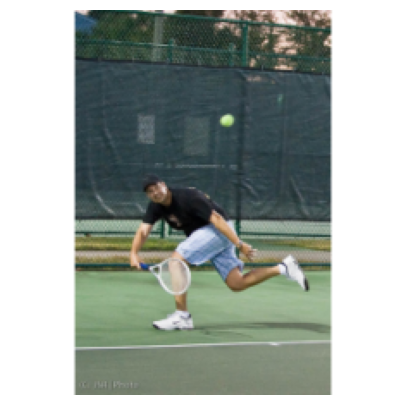

In [ ]:

# let's also see a couple examples of the dataset 

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import random

original_dataset = load_dataset("RIW/small-coco")
idx = random.randint(0, len(dataset)-1)  # random index

# Get original caption
original_caption = original_dataset['train'][idx]['caption']

image, caption = dataset[idx]

# tensor back to PIL Image for display
unnorm = ToPILImage()(image)

plt.figure(figsize=(10, 5))
plt.imshow(unnorm)
plt.axis('off')

decoded_caption = [list(vocab.keys())[list(vocab.values()).index(idx)] for idx in caption.tolist()]
decoded_caption = ' '.join([word for word in decoded_caption if word not in ['<PAD>', '<START>', '<END>']])

print("\nImage index:", idx)
print("Original caption:", original_caption)
print("Processed caption:", decoded_caption)
plt.show()

In [ ]:
# now, let's look at the raw tokens before indexing
print("\nDebugging caption processing:")
print("Sample original tokens:", tokens[14])  # from your original tokenization

# Look at what happens after indexing
print("\nAfter indexing:")
print("Sample indexed caption:", indexed_captions[14])

# Let's see how special tokens were added
print("\nSpecial tokens in vocab:")
for token in ['<PAD>', '<UNK>', '<START>', '<END>']:
    print(f"{token}: {vocab.get(token)}")

print("\nFirst few tokens of multiple captions:")
for i in range(3):
    print(f"Caption {i}:", indexed_captions[i][:5])

print("\nFirst few vocabulary items:")
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1])
print(dict(sorted_vocab[:10]))


Debugging caption processing:
Sample original tokens: ['a', 'young', 'boy', 'standing', 'in', 'front', 'of', 'a', 'computer', 'keyboard', '.']

After indexing:
Sample indexed caption: [2, 4, 24, 65, 72, 36, 74, 21, 4, 75, 76, 14, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Special tokens in vocab:
<PAD>: 0
<UNK>: 1
<START>: 2
<END>: 3

First few tokens of multiple captions:
Caption 0: [2, 4, 5, 6, 4]
Caption 1: [2, 5, 15, 4, 16]
Caption 2: [2, 4, 5, 15, 9]

First few vocabulary items:
{'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3, 'a': 4, 'man': 5, 'with': 6, 'red': 7, 'helmet': 8, 'on': 9}


In [ ]:
# Training loop
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
model = ImageCaptioningModel(embed_size, hidden_size, vocab_size).to("cuda")
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (ims, caps) in enumerate(dataloader):
        ims, caps = ims.to("cuda"), caps.to("cuda")
        
        # Calculate lengths and keep them on CPU
        lengths = (caps != vocab['<PAD>']).sum(dim=1).cpu()
        
        optimizer.zero_grad()

        # Forward pass through the combined model
        outputs = model(ims, caps, lengths)  # [32, 18, 4673]
        
        # Get the shorter sequence length
        seq_length = min(outputs.size(1), caps.size(1)-1)
        
        # Truncate both tensors to the same sequence length
        outputs = outputs[:, :seq_length, :].contiguous()  # Remove extra sequence steps
        caps = caps[:, 1:seq_length+1].contiguous()  # Remove first token (<START>) and match sequence length
        
        # Reshape for loss calculation
        outputs = outputs.view(-1, vocab_size)
        caps = caps.view(-1)
        
        # Calculate loss
        loss = criterion(outputs, caps)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}')
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/10], Step [100/310], Loss: 4.8499
Epoch [1/10], Step [200/310], Loss: 4.9050
Epoch [1/10], Step [300/310], Loss: 4.1191
Epoch 1/10, Average Loss: 4.8606
Epoch [2/10], Step [100/310], Loss: 4.5677
Epoch [2/10], Step [200/310], Loss: 3.9665
Epoch [2/10], Step [300/310], Loss: 4.1406
Epoch 2/10, Average Loss: 4.1056
Epoch [3/10], Step [100/310], Loss: 3.6116
Epoch [3/10], Step [200/310], Loss: 4.0079
Epoch [3/10], Step [300/310], Loss: 3.7144
Epoch 3/10, Average Loss: 3.7403
Epoch [4/10], Step [100/310], Loss: 3.3153
Epoch [4/10], Step [200/310], Loss: 3.4378
Epoch [4/10], Step [300/310], Loss: 3.6592
Epoch 4/10, Average Loss: 3.4854
Epoch [5/10], Step [100/310], Loss: 3.0035
Epoch [5/10], Step [200/310], Loss: 3.3999
Epoch [5/10], Step [300/310], Loss: 3.1470
Epoch 5/10, Average Loss: 3.2670
Epoch [6/10], Step [100/310], Loss: 3.1571
Epoch [6/10], Step [200/310], Loss: 3.2841
Epoch [6/10], Step [300/310], Loss: 3.1283
Epoch 6/10, Average Loss: 3.0754
Epoch [7/10], Step [100/310]

In [75]:
# save the model dict so it can easily be loaded and run later

torch.save(model.state_dict(), 'model_state_dict.pt')

# Inference

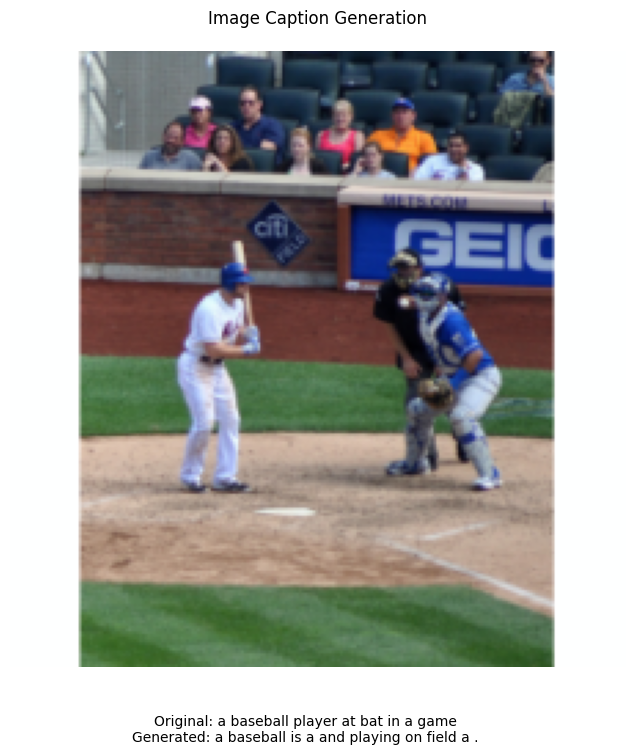

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

def decode_caption(encoded_caption, vocab):
    # Create reverse mapping from index to word
    idx_to_word = {idx: word for word, idx in vocab.items()}
    words = []
    
    if isinstance(encoded_caption, np.ndarray):
        encoded_caption = encoded_caption.tolist()
    
    for idx in encoded_caption:
        word = idx_to_word.get(idx, '<UNK>')
        if word == '<END>':
            break
        if word not in ['<START>', '<PAD>', '<UNK>']:
            words.append(word)
    
    return ' '.join(words)

def evaluate_single_entry(model, dataset, vocab, index):
    model.eval() 
    
    image, caption_encoded = dataset[index]
    image = image.unsqueeze(0).to("cuda")
    
    with torch.no_grad():
        sampled_ids = model.sample(image)
        sampled_ids = sampled_ids.cpu().numpy()
    
    original_caption = decode_caption(caption_encoded.numpy(), vocab)
    generated_caption = decode_caption(sampled_ids[0], vocab)

    img = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title('Image Caption Generation', pad=20)
    plt.figtext(0.5, 0.02, f'Original: {original_caption}\nGenerated: {generated_caption}', 
                ha='center', wrap=True, fontsize=10)
    plt.axis('off')
    plt.show()

def evaluate_random_samples(model, dataset, vocab, num_samples=5):
    """Evaluate multiple random samples from the dataset"""
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        print(f"\nSample {idx}:")
        evaluate_single_entry(model, dataset, vocab, idx)
        plt.close()  


specific_index = random.randint(0, len(dataset) - 1)
evaluate_single_entry(model, dataset, vocab, specific_index)


In [79]:
# load the model dict

from torchvision import models
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Lambda

resnet = models.resnet50(pretrained=True)


transform = Compose([
    Lambda(lambda img: img.convert("RGB")),
    Resize((224, 224)),   # because we're gonna use resnet
    ToTensor()
])


model = ImageCaptioningModel(resnet, vocab_size=len(vocab) + 1).to(device)
model.load_state_dict(torch.load('model_state_dict.pt'))


C:\Users\kaczm\AppData\Local\Temp\ipykernel_10164\2524458698.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state_dict.pt'))


<All keys matched successfully>

Generated caption: a bird in shape a plane in sky


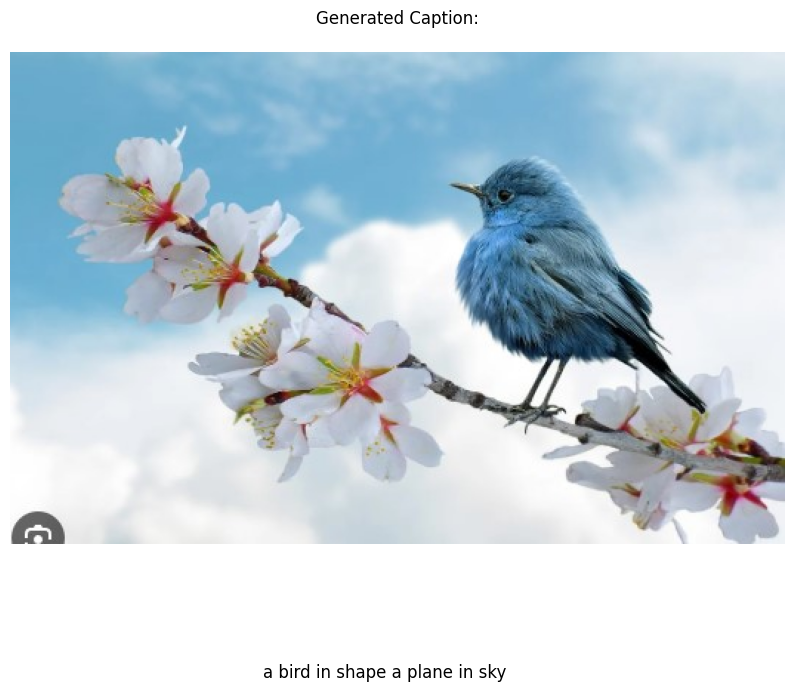

In [155]:
from PIL import Image
import torch
from torchvision import transforms

def generate_caption(model, image_path, transform, vocab):
    """
    Generate a caption for a given image using the trained model
    
    Args:
        model: Trained ImageCaptioningModel
        image_path: Path to the image file
        transform: Image transformation pipeline
        vocab: Vocabulary dictionary
    """
    # Create reverse mapping of vocab
    idx_to_word = {idx: word for word, idx in vocab.items()}
    
    # Load and transform image
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to("cuda")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    # Generate caption
    model.eval()
    with torch.no_grad():
        try:
            sampled_ids = model.sample(image)
            sampled_ids = sampled_ids.cpu().numpy()[0]
        except Exception as e:
            print(f"Error generating caption: {e}")
            return None
    
    # Convert indices to words
    caption = []
    for word_id in sampled_ids:
        word = idx_to_word.get(word_id, '<UNK>')
        if word == '<END>':
            break
        if word not in ['<START>', '<PAD>', '<UNK>']:
            caption.append(word)
    
    return ' '.join(caption)

def display_image_and_caption(image_path, caption):
    """Display the image with its generated caption"""
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title('Generated Caption:', pad=20)
    plt.figtext(0.5, 0.02, caption, ha='center', wrap=True, fontsize=12)
    plt.axis('off')
    plt.show()

# Example usage
# Define the transformation pipeline if not already defined
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Generate caption for a specific image
image_path = "C:/Users/kaczm/Downloads/bird.jpg"
caption = generate_caption(model, image_path, transform, vocab)

if caption:
    print(f"Generated caption: {caption}")
    display_image_and_caption(image_path, caption)



# Debugging

In [19]:
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# maximum caption index
max_index = max(max(caption) for caption in indexed_captions if caption)
print("Maximum token index in captions:", max_index)

assert max_index < vocab_size, "Caption indices exceed vocabulary size!"

# so the issue was here

Vocabulary Size: 4671
Maximum token index in captions: 4671


AssertionError: Caption indices exceed vocabulary size!

In [19]:
print(f"Vocabulary size: {len(vocab)}")
print(f"Vocabulary keys: {list(vocab.keys())[:10]}")  # Print the first 10 keys

Vocabulary size: 4671
Vocabulary keys: ['<PAD>', '<UNK>', 'a', 'man', 'with', 'red', 'helmet', 'on', 'small', 'moped']


In [20]:
print(f"Captions range: {captions.min().item()} to {captions.max().item()}")

AttributeError: 'list' object has no attribute 'min'

In [21]:
for idx, caption in enumerate(captions):
    if caption.max().item() >= len(vocab):
        print(f"Invalid index in caption {idx}: {caption.max().item()}")

AttributeError: 'str' object has no attribute 'max'

In [49]:
model = ImageCaptioningModel(resnet, vocab_size=len(vocab))

print(model)

ImageCaptioningModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [13]:
device = torch.device('cpu')  # Use CPU for debugging
model = ImageCaptioningModel(resnet, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=1e-4)


NameError: name 'ImageCaptioningModel' is not defined

In [77]:
# debugging - checking cpu training
# create function to train the model
def train_resnet_on_coco_cpu(model, dataloader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (images, captions) in enumerate(dataloader):

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions[:, :-1])
            outputs = outputs.contiguous().view(-1, outputs.size(-1))  # (batch_size * seq_length, vocab_size)
            targets = captions[:, 1:].contiguous().view(-1)  # (batch_size * seq_length)

            # Debug shapes and values


            # Compute loss
            loss = criterion(outputs, targets)
            loss.backward()

            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"{name}: grad min {param.grad.min()}, grad max {param.grad.max()}")
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

In [80]:
train_resnet_on_coco_cpu(model, dataloader, criterion, optimizer, device, epochs=5)

feature_proj.weight: grad min -0.00027508128550834954, grad max 0.00026733241975307465
feature_proj.bias: grad min -0.0002101191639667377, grad max 0.0001954742183443159
embed.weight: grad min -0.0004930500872433186, grad max 0.0005073818610981107
lstm.weight_ih_l0: grad min -0.004378886893391609, grad max 0.004095211625099182
lstm.weight_hh_l0: grad min -0.0008630090160295367, grad max 0.0009187074610963464
lstm.bias_ih_l0: grad min -0.0054651591926813126, grad max 0.0057990215718746185
lstm.bias_hh_l0: grad min -0.0054651591926813126, grad max 0.0057990215718746185
fc.weight: grad min -0.016872864216566086, grad max 0.013797080144286156
fc.bias: grad min -0.09124822914600372, grad max 0.00024286108964588493


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [61]:
print(f"Padding index (ignore_index): {vocab['<PAD>']}")
print(f"Vocabulary size: {len(vocab)}")

Padding index (ignore_index): 0
Vocabulary size: 4671


In [15]:

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

images, captions = next(iter(dataloader))
images, captions = images.to(device), captions.to(device)

outputs = model(images, captions[:, :-1])
outputs = outputs.contiguous().view(-1, outputs.size(-1))
targets = captions[:, 1:].contiguous().view(-1)

print(f"Targets range: {targets.min().item()}, {targets.max().item()}")
if (targets < 0).any() or (targets >= len(vocab)).any():
    print("Invalid target indices detected.")

loss = criterion(outputs, targets)
print(f"Loss: {loss.item()}")

loss.backward()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name}: grad min {param.grad.min().item()}, grad max {param.grad.max().item()}")
        if not torch.isfinite(param.grad).all():
            print(f"Invalid gradient detected in {name}. Stopping.")
            break
    else:
        print(f"{name}: no gradient")


optimizer.step()


NameError: name 'model' is not defined

In [14]:
class SimpleModel(nn.Module):
    def __init__(self, base_model, vocab_size):
        super(SimpleModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Identity()
        self.fc = nn.Linear(2048, vocab_size)

    def forward(self, images, captions):
        features = self.base_model(images)  # Extract features
        return self.fc(features)

simple_model = SimpleModel(resnet, vocab_size=len(vocab)).to(device)

# Train with the simplified model
outputs = simple_model(images, captions)

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile, PngImageFile,

In [115]:
# Define the SimpleModel
class SimpleModel(nn.Module):
    def __init__(self, base_model, vocab_size, max_caption_length=25):
        super(SimpleModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Identity()
        self.fc = nn.Linear(2048, vocab_size)
        self.max_caption_length = max_caption_length

    def forward(self, images, captions):
        features = self.base_model(images)  # Shape: (batch_size, 2048)
        features = features.unsqueeze(1)  # Add sequence dimension: (batch_size, 1, 2048)
        features = features.expand(-1, self.max_caption_length, -1)  # Repeat for max_caption_length
        outputs = self.fc(features)  # Shape: (batch_size, max_caption_length, vocab_size)
        return outputs
    
# Initialize the simplified model
simple_model = SimpleModel(resnet, vocab_size=len(vocab)).to(device)

# Define optimizer and loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, simple_model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

def train_simple_model(model, dataloader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (images, captions) in enumerate(dataloader):
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions)  # (batch_size, seq_length, vocab_size)
            outputs = outputs[:, :-1, :].contiguous().view(-1, outputs.size(-1))  # (batch_size * max_caption_length, vocab_size)
            targets = captions[:, 1:].contiguous().view(-1)            # (batch_size * seq_length)

            print(f"Outputs shape: {outputs.shape}")
            print(f"Targets shape: {targets.shape}")

            print(f"Targets range: {targets.min().item()}, {targets.max().item()}")
            if (targets < 0).any() or (targets >= len(vocab)).any():
                raise ValueError("Invalid target indices detected.")

            # Compute loss

            print(f"Outputs max: {outputs.max().item()}, min: {outputs.min().item()}")
            print(f"Targets unique values: {targets.unique()}")

            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

# Run the training
train_simple_model(simple_model, dataloader, criterion, optimizer, device, epochs=5)

Outputs shape: torch.Size([768, 4671])
Targets shape: torch.Size([768])
Targets range: 0, 4531
Outputs max: 1.436654806137085, min: -1.4599909782409668
Targets unique values: tensor([   0,    3,    4,    5,    8,    9,   13,   14,   17,   20,   21,   26,
          31,   35,   37,   38,   40,   41,   42,   44,   47,   49,   53,   56,
          58,   59,   64,   65,   71,   73,   74,   78,   79,   86,   96,   98,
          99,  102,  103,  106,  109,  114,  126,  143,  149,  160,  167,  173,
         174,  176,  182,  193,  196,  197,  199,  204,  205,  206,  214,  215,
         226,  244,  250,  252,  258,  262,  280,  286,  294,  303,  305,  310,
         316,  328,  338,  341,  346,  347,  356,  357,  363,  365,  369,  377,
         383,  387,  398,  399,  403,  419,  431,  438,  478,  481,  500,  528,
         542,  559,  571,  572,  580,  592,  604,  605,  636,  637,  649,  666,
         669,  685,  689,  693,  707,  722,  724,  732,  733,  738,  753,  759,
         763,  767,  797,

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [109]:
print(f"Outputs shape: {outputs.shape}")
print(f"Targets shape: {targets.shape}")

Outputs shape: torch.Size([32, 4671])
Targets shape: torch.Size([768])
